In [1]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# images and display
from IPython.display import Markdown as md
from IPython import display

# Plastock - Iqaasl

In [2]:
plastock = pd.read_csv("data/20230314macro.csv", sep=";", encoding="ISO-8859-3")
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")
p_beaches = pd.read_csv("data/asl_beaches2.csv")

In [3]:
# the location names in asl_beaches does not match the names in 20230314macro.csv
# the names in the asl_beaches file were changed previously
# they need to be changed back to match the new survey data
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# check eqaulity
print(p_names == pstock_names)

# however the lengths are the same
print(len(p_names) == len(pstock_names))

False
True


In [4]:
# the differences are capitalizations and hyphenations
renames = {x: p_names[i] for i, x in enumerate(pstock_names)}
renames

{'Amphion': 'Amphion',
 'Anthy-Séchex': 'Anthy',
 'Aubonne': 'Aubonne',
 'Baby Plage': 'Baby Plage',
 'Bouveret': 'Bouveret',
 'Clarens': 'Clarens',
 'Crans': 'Crans',
 'Cully': 'Cully',
 'Excenevex': 'Excenevex',
 'Gland': 'Gland',
 'Grangettes': 'Grangettes',
 'Hermance': 'Hermance',
 'Lugrin': 'Lugrin',
 'Lutry': 'Lutry',
 'Meillerie': 'Meillerie',
 'Pichette': 'Pichette',
 'Port choiseul': 'Port Choiseul',
 'Préverenges': 'Préverenges',
 'Rolle': 'Rolle',
 'Saint-Disdille': 'Saint-Disdille',
 'Savonnière': 'Savonière',
 'Tolochenaz': 'Tolochenaz',
 'Tougues': 'Tougues',
 'Versoix': 'Versoix',
 'Vidy': 'Vidy'}

In [5]:
plastock["Lieu"] = plastock.Lieu.apply(lambda x: renames[x])
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# check eqaulity
print(p_names == pstock_names)

True


In [6]:
# the length needs to be added to the survey data
# make a map name => beach length from p_beaches
name_map = p_beaches.drop_duplicates("location")
name_map = name_map.set_index("location")
name_map = name_map["length"]
name_map.loc["Port Choiseul"]

78

In [7]:
# apply map to the survey data
plastock["Length"] = plastock.Lieu.map(lambda x: name_map.loc[x])

# we are only interested in certain columns
cols = ['Lieu', 'Date', 'Code', 'Quantité', "Length", 'Temps', 'Position', 'Substrat',  'Saison',  'Objet']
plastock = plastock[cols].copy()


# we need a loc_date (unique survey id) column and set the date to iso
plastock["loc_date"] = list(zip(plastock["Lieu"], plastock["Date"]))
plastock["loc_date"] = plastock.loc_date.astype(str)

# convert to datetime
plastock["date"] = pd.to_datetime(plastock["Date"], format="%d.%m.%Y").dt.date

# we only need certain columns from the iqaasl data
work_columns = ['location', 'loc_date', 'date', 'code', 'pcs_m', 'quantity']
iqaasl = iqaasl[work_columns]
iqaasl["project"] = "iqaasl"

# we need to convert quantity to pcs/m in the plastock data
plastock['pcs_m'] = plastock["Quantité"]/plastock.Length

# the column names in the plastock data and iqaasl data need to be the same
renames = {"Lieu":"location", "Code":"code", "Quantité":"quantity"}
pstock = plastock.rename(columns=renames)
pstock = pstock[work_columns]
pstock["project"] = "plastock"

pstock.head()

,location,loc_date,date,code,pcs_m,quantity,project
0,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G10,0.010989,1,plastock
1,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G103,0.076923,7,plastock
2,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G106,0.186813,17,plastock
3,Amphion,"('Amphion', '19.07.2022')",2022-07-19,G112,0.010989,1,plastock
4,Amphion,"('Amphion', '01.02.2022')",2022-02-01,G113,0.010989,1,plastock


In [8]:
iqaasl.head()

,location,loc_date,date,code,pcs_m,quantity,project
0,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G191,0.01,1,iqaasl
1,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G35,0.01,1,iqaasl
2,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G21,0.01,1,iqaasl
3,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G67,0.03,2,iqaasl
4,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G23,0.01,1,iqaasl


In [9]:
iqaasl.code.unique()

array(['G191', 'G35', 'G21', 'G67', 'G23', 'G142', 'G26', 'G157', 'G30',
       'G939', 'G182', 'G33', 'G200', 'G66', 'G22', 'G10', 'G25', 'G89',
       'G156', 'G28', 'G921', 'G178', 'G32', 'G95', 'G194', 'G51', 'G213',
       'G24', 'G155', 'G27', 'G177', 'G31', 'G940', 'G159', 'G73', 'G208',
       'G922', 'G12', 'G145', 'G165', 'G198', 'G923', 'G126', 'G134',
       'G148', 'G48', 'G933', 'G905', 'G3', 'G914', 'G147', 'G34', 'G96',
       'G904', 'G91', 'G100', 'G137', 'G149', 'G170', 'G90', 'G38',
       'G938', 'G937', 'G943', 'G193', 'G131', 'G203', 'G11', 'G204',
       'G918', 'G175', 'G13', 'G936', 'G70', 'G211', 'G930', 'G93',
       'G929', 'G135', 'G87', 'G153', 'G98', 'G112', 'G125', 'G106',
       'G103', 'G124', 'G50', 'G20', 'G108', 'G941', 'G152', 'G107',
       'G942', 'G99', 'G173', 'G916', 'G65', 'G928', 'G43', 'G908',
       'G101', 'G128', 'G117', 'G64', 'G2', 'G97', 'G907', 'G917', 'G931',
       'G900', 'G202', 'G146', 'G4', 'G197', 'G144', 'G115', 'G906',
    

In [10]:
# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['loc_date', 'location', 'date', 'quantity', 'project']
operations = {"quantity":"sum", "pcs_m": "sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pstock_gfrags = pstock[pstock.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
pstock_gfoam = pstock[pstock.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
pstock_gcaps = pstock[pstock.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

pstock_gcaps["code"] = "Gcaps"
pstock_gfoam["code"] = "Gfoam"
pstock_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
pstock_no_frags = pstock[~pstock.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# combine with 
pstock = pd.concat([pstock_no_frags, pstock_gfrags, pstock_gfoam, pstock_gcaps])

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqaasl[~iqaasl.code.isin(Gcaps)].copy()
iqaasl_caps = iqaasl[iqaasl.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)
iqaasl_caps["code"] = "Gcaps"

iqaasl = pd.concat([iqaasl_caps, iqaasl_not_caps])

In [11]:
pstock_gfoam

,loc_date,location,date,project,quantity,pcs_m,code
0,"('Amphion', '01.02.2022')",Amphion,2022-02-01,plastock,4,0.043956,Gfoam
1,"('Amphion', '01.02.2022')",Amphion,2022-02-01,plastock,14,0.153846,Gfoam
2,"('Amphion', '01.02.2022')",Amphion,2022-02-01,plastock,43,0.472527,Gfoam
3,"('Amphion', '03.05.2022')",Amphion,2022-05-03,plastock,10,0.109890,Gfoam
4,"('Amphion', '03.05.2022')",Amphion,2022-05-03,plastock,16,0.175824,Gfoam
...,...,...,...,...,...,...,...
135,"('Versoix', '30.04.2022')",Versoix,2022-04-30,plastock,6,0.200000,Gfoam
136,"('Vidy', '12.07.2022')",Vidy,2022-07-12,plastock,1,0.014085,Gfoam
137,"('Vidy', '12.07.2022')",Vidy,2022-07-12,plastock,3,0.042254,Gfoam
138,"('Vidy', '13.05.2022')",Vidy,2022-05-13,plastock,1,0.014085,Gfoam


In [12]:
pstock.code.unique()

array(['G10', 'G103', 'G106', 'G112', 'G113', 'G114', 'G117', 'G125',
       'G131', 'G135', 'G145', 'G148', 'G2', 'G211', 'G25', 'G27', 'G29',
       'G30', 'G31', 'G32', 'G35', 'G49', 'G50', 'G66', 'G70', 'G74',
       'G89', 'G905', 'G914', 'G922', 'G931', 'G932', 'G95', 'G97', 'G99',
       'G132', 'G134', 'G53', 'G34', 'G126', 'G128', 'G137', 'G194',
       'G216', 'G26', 'G73', 'G901', 'G904', 'G926', 'G100', 'G101',
       'G12', 'G133', 'G144', 'G18', 'G28', 'G33', 'G67', 'G90', 'G937',
       'G39', 'G4', 'G54', 'G138', 'G61', 'G51', 'G7', 'G129', 'G136',
       'G41', 'G139', 'Gfrags', 'Gfoam', 'Gcaps'], dtype=object)

In [13]:
combined = pd.concat([pstock, iqaasl])

# we are only using the valid codes from plastock
codes = pstock.code.unique()
workdata = combined[combined.code.isin(codes)]

## scatter plot by date

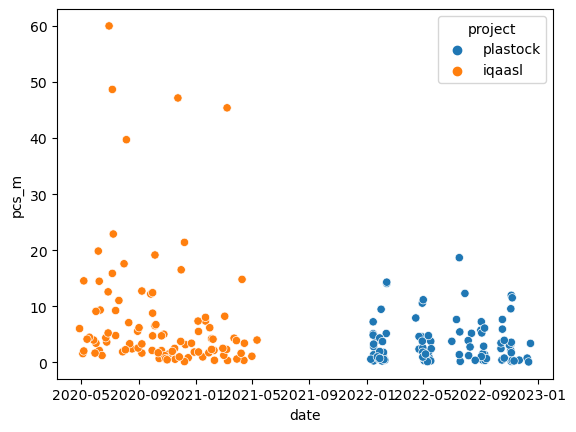

In [14]:
# we need to aggregate by sample
daily_totals = workdata.groupby(["loc_date", "date", "project"], as_index=False).pcs_m.sum()

fig, ax = plt.subplots()

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax, hue="project")


plt.show()

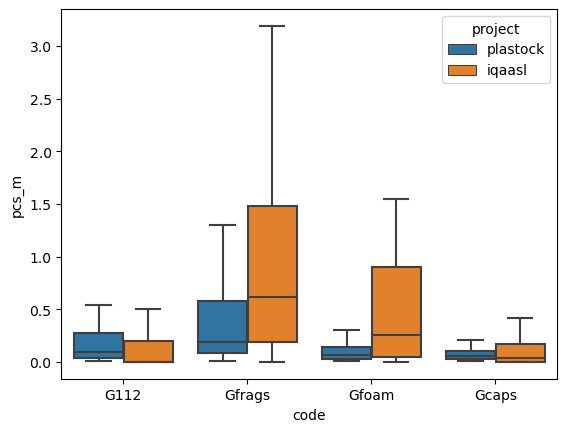

In [16]:
# compare code values
# choose a code
codes = ["G112", "Gcaps", "Gfoam", "Gfrags"]


fig, ax = plt.subplots()

sns.boxplot(data=workdata[workdata.code.isin(codes)], x="code", y="pcs_m", ax=ax, hue="project", showfliers=False)


plt.show()

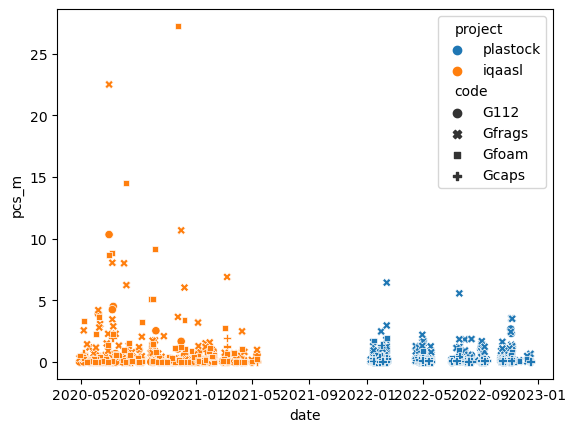

In [17]:
# we need to aggregate by sample
daily_totals = workdata[workdata.code.isin(codes)]

fig, ax = plt.subplots()

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax, hue="project", style="code")


plt.show()

In [18]:
daily_totals.groupby(["project", "code"]).pcs_m.describe()

count      mean       std       min       25%       50%  \
project  code                                                              
iqaasl   G112     98.0  0.403367  1.290020  0.000000  0.000000  0.000000   
         Gcaps   224.0  0.140625  0.257862  0.000000  0.000000  0.040000   
         Gfoam    98.0  1.288163  3.465841  0.000000  0.045000  0.260000   
         Gfrags   98.0  1.505816  2.872184  0.000000  0.185000  0.615000   
plastock G112     51.0  0.303617  0.537976  0.008000  0.040833  0.098765   
         Gcaps   145.0  0.090557  0.137623  0.008333  0.028169  0.051724   
         Gfoam   140.0  0.146780  0.261001  0.008000  0.029870  0.069048   
         Gfrags  297.0  0.452733  0.715983  0.008333  0.080000  0.185714   

                      75%        max  
project  code                         
iqaasl   G112    0.200000  10.330000  
         Gcaps   0.170000   1.960000  
         Gfoam   0.900000  27.250000  
         Gfrags  1.482500  22.500000  
plastock G112    0.270180   2.664000  
         Gcaps   0.100000   1.373626  
         Gfoam   0.143750   1.969697  
         Gfrags  0.581818   6.433333